# Physics 512 -  Problem Set 3

Kit M. Gerodias

Required modules and functions for the following problems.

In [1]:
#[ IMPORT Modules ]

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import display, Markdown
import camb
import time
import corner
from statsmodels.stats.weightstats import DescrStatsW

In [2]:
#modified code from class

#[ Newton's Method ]
def f(x,params,constParam):
    #x is data
    derivs=np.zeros([len(x),len(params)])
    xlen = len(x)
    
    for i in range(len(params)):
        
        if i == constParam:
            #print("Skipping parameter",i+1,"...")
            derivs[:,i] = 0
            
        else:
            #print("Calculating derivative for parameter",i+1,"...")
            dh = 0.000001*params[i]
            #print(dh)
            foreParams = params.copy()    
            foreParams[i] = params[i] + dh
            #print(foreParams)
            foreFunc = get_spectrum(foreParams)[2:xlen+2,]

            backParams = params.copy()     
            backParams[i] = params[i] - dh
            backFunc = get_spectrum(backParams)[2:xlen+2,]
            derivs[:,i] = (foreFunc - backFunc)/(2*dh)
            #personal note: got stuck with derivs for three days!!!
            #Forgot to enclose 2*dh with parenthesis :( ... thus, the new iteration step would blow up!
            
    return derivs
            

In [3]:
#sample code from class

#[ CAMB code ]
def get_spectrum(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt


# Problem No. 1

In [2]:
#[ input data ]
file = np.loadtxt("dish_zenith.txt")
xdata = file[:,0]
ydata = file[:,1]
zdata = file[:,2]

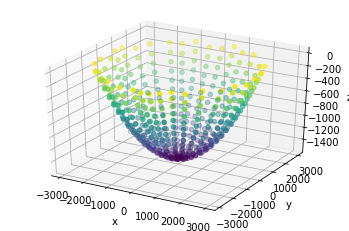

In [29]:
# Data for three-dimensional scattered points
#viewing the data
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata, c=zdata)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Attempting to learn writing equations in jupyter...

The given rotationally symmetric paraboloid equation, $$z - z_0 =a((x-x_0)^2 + (y-y_0)^2)$$
is equivalent to, $$z = ax^2 + ay^2 -2ax_0 x - 2ay_0 y + ax_0^2 + ay_0^2 + z_0.$$
\
Thus, comparing $z = A_0x^2 + B_0y^2 + A_1x + B_1y + C$, we get the following relations:\
$A_0 = B_0 = a$\
$A_1 = -2ax_0$\
$B_1 = -2ay_0$\
$C = ax_0^2 + ay_0^2 + z_0.$

In [38]:
#based from code in class

def paraboloid(x,y):
    A=np.zeros([len(x), 4])
    A[:,0] = x**2 + y**2 # for A0 = B0 = a
    A[:,1] = x # for A1
    A[:,2] = y # for B1
    A[:,3] = 1 # for C
    return A

In [42]:
#[ Data Fitting ]
A = paraboloid(xdata,ydata)
u,s,v=np.linalg.svd(A,0)
print('svd condition is ',s.max()/np.abs(s).min())
fitp_svd=v.T@(np.diag(1/s)@(u.T@zdata))
z_pred_svd=A@fitp_svd
#plt.plot(x,y_pred_svd)

svd condition is  8726556.680632548


In [43]:
fitp_svd

array([ 1.66704455e-04,  4.53599026e-04, -1.94115589e-02, -1.51231182e+03])

In [57]:
#print
display(Markdown(
   rf"""
Best-fit parameters\
$A_0 = B_0 = {fitp_svd[0]:.3e}$\
$A_1 = {fitp_svd[1]:.3e}$\
$B_1 = {fitp_svd[2]:.3e}$\
$C = {fitp_svd[3]:.3e}$
"""))


Best-fit parameters\
$A_0 = B_0 = 1.667e-04$\
$A_1 = 4.536e-04$\
$B_1 = -1.941e-02$\
$C = -1.512e+03$


In [59]:
#[ Original Parameters ]
a = fitp_svd[0]
x0 = -fitp_svd[1]/(2*a)
y0 = -fitp_svd[2]/(2*a)
z0 = fitp_svd[3] - (a*x0**2) - (a*y0**2)
#print
display(Markdown(
   rf"""
Original best-fit parameters\
$a = {a:.3e}$\
$x_0 = {x0:.3e}$\
$y_0 = {y0:.3e}$\
$z_0 = {z0:.3e}$
"""))


Original best-fit parameters\
$a = 1.667e-04$\
$x_0 = -1.360e+00$\
$y_0 = 5.822e+01$\
$z_0 = -1.513e+03$


From $z = A_0x^2 + B_0y^2 ...$ with $ A_0 = B_0 = a $, for a focal length, $f$, $a = 1/4f$. Thus, $f = 1/4a$

In [76]:
f = (1/(4*a)/1000)
print("Focal length is {:.4f} meters.".format(f))

Focal length is 1.4997 meters.


In [84]:
#noise, rms
rms = np.std(zdata - z_pred_svd)
N=rms**2

#chisq=np.sum((zdata - z_pred_svd)**2)/N**2
#print("RMS scatter about fit is ",rms)

Ninv=np.eye(len(zdata))/N
lhs=A.T@Ninv@A
errs=np.sqrt(np.diag(np.linalg.inv(lhs)))

print("Estimated noise: {:.4f}".format(rms))
print("Uncertainty of a: {:.4e}".format(errs[0]))

Estimated noise: 3.7683
Uncertainty of a: 6.4519e-08


Error propagation: $\delta f = f (\delta a / a)$

In [102]:
#error propagation
error_f = (f*1000)*(errs[0]/a)
print("Focal length is {:.1f} ± {:.1f} millimeters.".format((f*1000),error_f))

Focal length is 1499.7 ± 0.6 millimeters.


# Problem No. 2

#### WMAP 9-year Data

Model\
Hubble constant: $\quad H_0 = 65$ $km/s$\
physical baryon density: $\quad \omega_bh^2 = 0.02 $\
cold dark matter density: $\quad \omega_ch^2 = 0.1 $\
optical depth: $\quad\quad\quad \tau = 0.05$\
primordial amplitude of fluctuations: $\quad A_s = 2 x 10^-9$\
slope of the primordial power law: $\quad n_s = 0.96$\
scaling by $h^2$: $ h = H_0/100 = 0.7$

<Figure size 432x288 with 0 Axes>

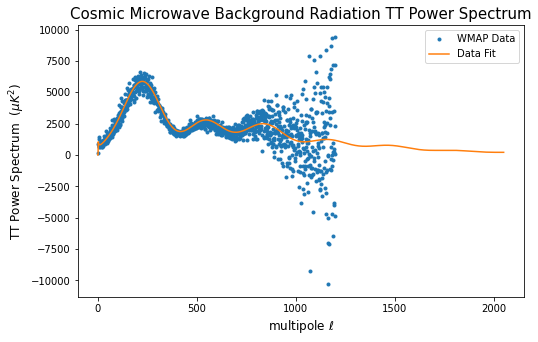

In [3]:
#sample code from class

pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
plt.figure(figsize=(8,5))
#plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
plt.plot(wmap[:,0],wmap[:,1],'.', label = 'WMAP Data')

cmb=get_spectrum(pars)

plt.plot(cmb, label = 'Data Fit')
plt.title("Cosmic Microwave Background Radiation TT Power Spectrum", fontsize = 15, loc='center')
plt.ylabel("TT Power Spectrum  $ (\mu K^2)$", fontsize = 12)
plt.xlabel("multipole $\ell$", fontsize = 12)
plt.legend()
plt.show()

In [74]:
#[ calculate Chi-squared]
wmapLen = len(wmap[:,1])
N = wmap[:,2] #error from data
chisq=np.sum((wmap[:,1]-cmb[2:wmapLen+2,])**2/N**2)

print("Chi-squared is ",chisq)

Chi-squared is  1588.2376532931526


1588!

# Problem No. 3

Parameter 1: $\quad H_0 = 65$ $km/s$\
Parameter 2: $\quad \omega_bh^2 = 0.02 $\
Parameter 3: $\quad \omega_ch^2 = 0.1 $\
Parameter 4: $\quad \tau = 0.05$\
Parameter 5: $\quad A_s = 2 x 10^-9$\
Parameter 6: $\quad n_s = 0.96$

In [27]:
wmapData = wmap[:,1]
pars = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
derivPars = f(wmapData,pars,3)

Calculating derivative for parameter 1 ...
Calculating derivative for parameter 2 ...
Calculating derivative for parameter 3 ...
Skipping parameter 4 ...
Calculating derivative for parameter 5 ...
Calculating derivative for parameter 6 ...


This plot is when dh is set as 1% factor of parameters.


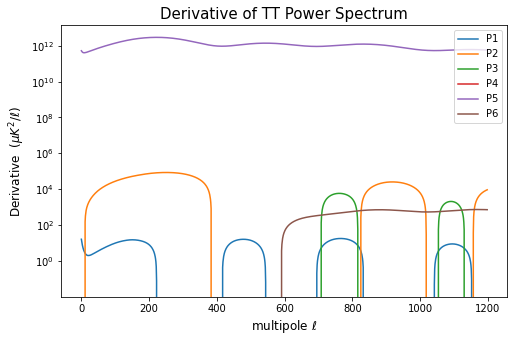

In [30]:
print("This plot is when dh is set as 1% factor of parameters.")
plt.figure(figsize=(8,5))
plt.plot(derivPars[0:,0], label = "P1")
plt.plot(derivPars[0:,1], label = "P2")
plt.plot(derivPars[0:,2], label = "P3")
plt.plot(derivPars[0:,3], label = "P4")
plt.plot(derivPars[0:,4], label = "P5")
plt.plot(derivPars[0:,5], label = "P6")
plt.yscale("log")
plt.legend(loc = 'upper right')
plt.title("Derivative of TT Power Spectrum", fontsize = 15, loc='center')
plt.ylabel("Derivative  $ (\mu K^2 / \ell)$", fontsize = 12)
plt.xlabel("multipole $\ell$", fontsize = 12)
plt.show()

This plot is when dh is set as 10^-6 factor of parameters.


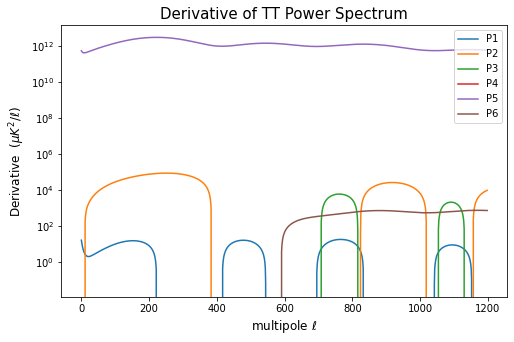

In [34]:
print("This plot is when dh is set as 10^-6 factor of parameters.")
derivPars = f(wmapData,pars,3)
plt.figure(figsize=(8,5))
plt.plot(derivPars[0:,0], label = "P1")
plt.plot(derivPars[0:,1], label = "P2")
plt.plot(derivPars[0:,2], label = "P3")
plt.plot(derivPars[0:,3], label = "P4")
plt.plot(derivPars[0:,4], label = "P5")
plt.plot(derivPars[0:,5], label = "P6")
plt.yscale("log")
plt.legend(loc = 'upper right')
plt.title("Derivative of TT Power Spectrum", fontsize = 15, loc='center')
plt.ylabel("Derivative  $ (\mu K^2 / \ell)$", fontsize = 12)
plt.xlabel("multipole $\ell$", fontsize = 12)
plt.show()

The two plots with different dh give an illustrative comparison of the estimated derivatives. Both of them are similar.

In [2]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [9]:
#[ setting Data ]
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
y = wmap[:,1]
ylen = len(y)
sig = wmap[:,2]
N = np.diag(sig**2) #error from data
Ninv = np.linalg.inv(N)
parameter  = 3 #making parameter no. constant
#chisq=np.sum((wmap[:,1]-cmb[2:wmapLen+2,])**2/N**2)

In [ ]:
#From lec 7
# m is parameters
# A_m = dA/dm = derivs 
# d is partial in this case
# derivs.T@(Ninv@resid) is rhs: [(A_m)^T] x [N^-1] x [ r ]
# N is covariance
# r is data - model
# derivs.T@Ninv@derivs is lhs: [(A_m)^T] x [N^-1] x [(A_m)^T]
# for new parameter step:
# m_(n+1) = m_n + inverse([(A_m)^T] x [N^-1] x [(A_m)^T]) x [(A_m)^T] x [N^-1] x [ r ]
# or in the code: np.linalg.inv(lhs)@rhs = np.linalg.inv(derivs.T@Ninv@derivs)@derivs.T@(Ninv@resid)

In [83]:
# modified from class


#[ guessing initial parameters ]
#c = 0.5
actualpars = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
#cfactor = np.asarray([c,c,c,1,c,c])
#pars_guess = actualpars*cfactor
pars_guess = actualpars
#pars_guess = np.asarray([60,0.015,0.11,0.05,1.8e-9,0.9])
pars_cur=pars_guess.copy()

#[ iterative Newton ]
start = time.time()
#y_init_raw = get_spectrum(actualpars)
#y_init = y_init_raw[2:ylen+2,]

for iter in range(5):
    try:
        y_raw = get_spectrum(pars_cur)
        y_pred = y_raw[2:ylen+2,]
        resid=y-y_pred #data minus current model
        print("Finding derivatives...")
        derivs_raw = f(y,pars_cur,parameter)
        
        
        #singular matrix problem
        #personal note: took me awhile to realize that the output includes a column with zero values
        #so determinant is zero which means no inverse can be calculated since it is a singular matrix
        derivs = np.delete(derivs_raw, parameter, axis=1)
        print("Calculating new parameters...")
        rhs=derivs.T@(Ninv@resid)
        lhs=derivs.T@Ninv@derivs
        step_raw=np.linalg.inv(lhs)@rhs
        
        step = np.insert(step_raw, parameter, 0, axis=0)
        #print(pars_cur)
        pars_cur=pars_cur+step
        #print(pars_cur)
        print('iteration ',iter,' has step ',step)
        if iter == 0:
            y_init = y_pred
            chisq=np.sum((resid)**2/sig**2)
            print("Initial chi-square:", chisq)
        else:
            prev_chisq = chisq
            chisq = np.sum((resid)**2/sig**2)
            print("New chi-square:", chisq)
            
            change_chisq = np.abs(chisq - prev_chisq)/prev_chisq
            if change_chisq < 0.01:
                break
    except:
        print('Problem with input values for get_spectrum()')
        break

par_errs_raw=np.sqrt(np.diag(np.linalg.inv(lhs)))
par_errs = np.insert(par_errs_raw, parameter, 0, axis=0)

end = time.time() - start

print('final parameters are ',pars_cur,' with errors ',par_errs)
print('process time:', end)

Finding derivatives...
Calculating new parameters...
iteration  0  has step  [2.35979277e+00 2.45392971e-03 1.61425104e-02 0.00000000e+00
 6.84334258e-11 6.40758271e-03]
Initial chi-square: 1588.2376532931526
Finding derivatives...
Calculating new parameters...
iteration  1  has step  [ 2.03599788e+00  3.06781219e-05 -2.42502282e-03  0.00000000e+00
 -2.61551230e-11  3.82118962e-03]
New chi-square: 1234.6994340397855
Finding derivatives...
Calculating new parameters...
iteration  2  has step  [-4.17675433e-02  1.33982022e-05  1.55846470e-04  0.00000000e+00
  9.30681575e-14 -3.00324650e-04]
New chi-square: 1227.9556494800495
final parameters are  [6.93540231e+01 2.24980060e-02 1.13873334e-01 5.00000000e-02
 2.04237137e-09 9.69928448e-01]  with errors  [2.41335364e+00 5.30001195e-04 5.25032528e-03 0.00000000e+00
 3.89402061e-11 1.36587948e-02]
process time: 70.05274438858032


In [84]:
print('Final parameters')
for i in range (len(pars_cur)):
    if i == 4:
        print("Parameter",i+1,": %.2e" % pars_cur[i],'±', "%.1e" % par_errs[i])
    else: 
        print("Parameter",i+1,": %.2f" % pars_cur[i],'±', "%.4f" % par_errs[i])

Final parameters
Parameter 1 : 69.35 ± 2.4134
Parameter 2 : 0.02 ± 0.0005
Parameter 3 : 0.11 ± 0.0053
Parameter 4 : 0.05 ± 0.0000
Parameter 5 : 2.04e-09 ± 3.9e-11
Parameter 6 : 0.97 ± 0.0137


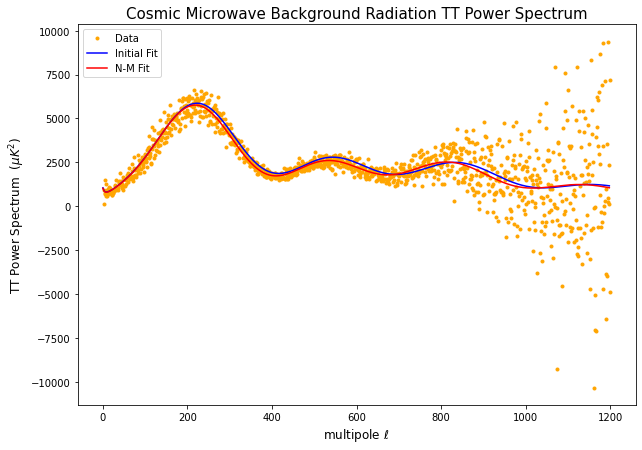

In [54]:
plt.figure(figsize=(10,7))
plt.plot(wmap[:,0],y,'.',label = 'Data',c='orange')
plt.plot(y_init,label = 'Initial Fit', c='b')
plt.plot(y_pred, label = 'N-M Fit', c='r')

plt.title("Cosmic Microwave Background Radiation TT Power Spectrum", fontsize = 15, loc='center')
plt.ylabel("TT Power Spectrum  $ (\mu K^2)$", fontsize = 12)
plt.xlabel("multipole $\ell$", fontsize = 12)
plt.legend()
plt.show()

In [90]:
# same code above but cleaner


#[ guessing initial parameters ]
parameter = None
pars_guess = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
pars_cur=pars_guess.copy()

#[ iterative Newton ]
start = time.time()

for iter in range(5):
    try:
        y_raw = get_spectrum(pars_cur)
        y_pred = y_raw[2:ylen+2,]
        resid=y-y_pred #data minus current model
        print("Finding derivatives...")
        #derivs_raw = f(y,pars_cur,parameter)
        derivs = f(y,pars_cur,parameter)
        #derivs = np.delete(derivs_raw, parameter, axis=1)
        print("Calculating new parameters...")
        rhs=derivs.T@(Ninv@resid)
        lhs=derivs.T@Ninv@derivs
        #step_raw=np.linalg.inv(lhs)@rhs
        step = np.linalg.inv(lhs)@rhs
        #step = np.insert(step_raw, parameter, 0, axis=0)
        pars_cur=pars_cur+step
        print('iteration ',iter,' has step ',step)
        if iter == 0:
            y_init = y_pred
            chisq=np.sum((resid)**2/sig**2)
            print("Initial chi-square:", chisq)
        else:
            prev_chisq = chisq
            chisq = np.sum((resid)**2/sig**2)
            print("New chi-square:", chisq)
            
            # if tau goes negative
            #if pars_cur[3] > 0:
            #    current_params = pars_cur
            #    lhs_check = lhs
            #else:
            #    print("Tau is negative.")
            
            change_chisq = np.abs(chisq - prev_chisq)/prev_chisq
            if change_chisq < 0.01:
                break
    except:
        print('Problem with input values for get_spectrum()')
        break


par_errs = np.sqrt(np.diag(np.linalg.inv(lhs)))
end = time.time() - start

print('process time:', end)

print('Final parameters')
for i in range (len(pars_cur)):
    if i == 4:
        print("Parameter",i+1,": %.2e" % pars_cur[i],'±', "%.1e" % par_errs[i])
    else: 
        print("Parameter",i+1,": %.2f" % pars_cur[i],'±', "%.4f" % par_errs[i])

Finding derivatives...
Calculating new parameters...
iteration  0  has step  [ 2.17120656e+00  2.41244262e-03  1.64511245e-02 -1.05541495e-02
  2.74222873e-11  4.88889364e-03]
Initial chi-square: 1588.2376532931526
Finding derivatives...
Calculating new parameters...
iteration  1  has step  [ 1.35469393e+00 -8.23911465e-05 -1.11207552e-03 -2.89788766e-02
 -1.39271944e-10 -7.67232135e-04]
New chi-square: 1235.398870041362
Finding derivatives...
Calculating new parameters...
iteration  2  has step  [-5.27188588e-03 -3.30703950e-05 -8.10676262e-05 -2.91556331e-02
 -1.06536824e-10 -6.18432933e-04]
New chi-square: 1228.3038822410788
process time: 88.24391865730286
Final parameters
Parameter 1 : 68.52 ± 2.7092
Parameter 2 : 0.02 ± 0.0006
Parameter 3 : 0.12 ± 0.0057
Parameter 4 : -0.02 ± 0.1416
Parameter 5 : 1.78e-09 ± 5.3e-10
Parameter 6 : 0.96 ± 0.0167


The parameter $ \tau $ went negative and the new chi-square is lowest.

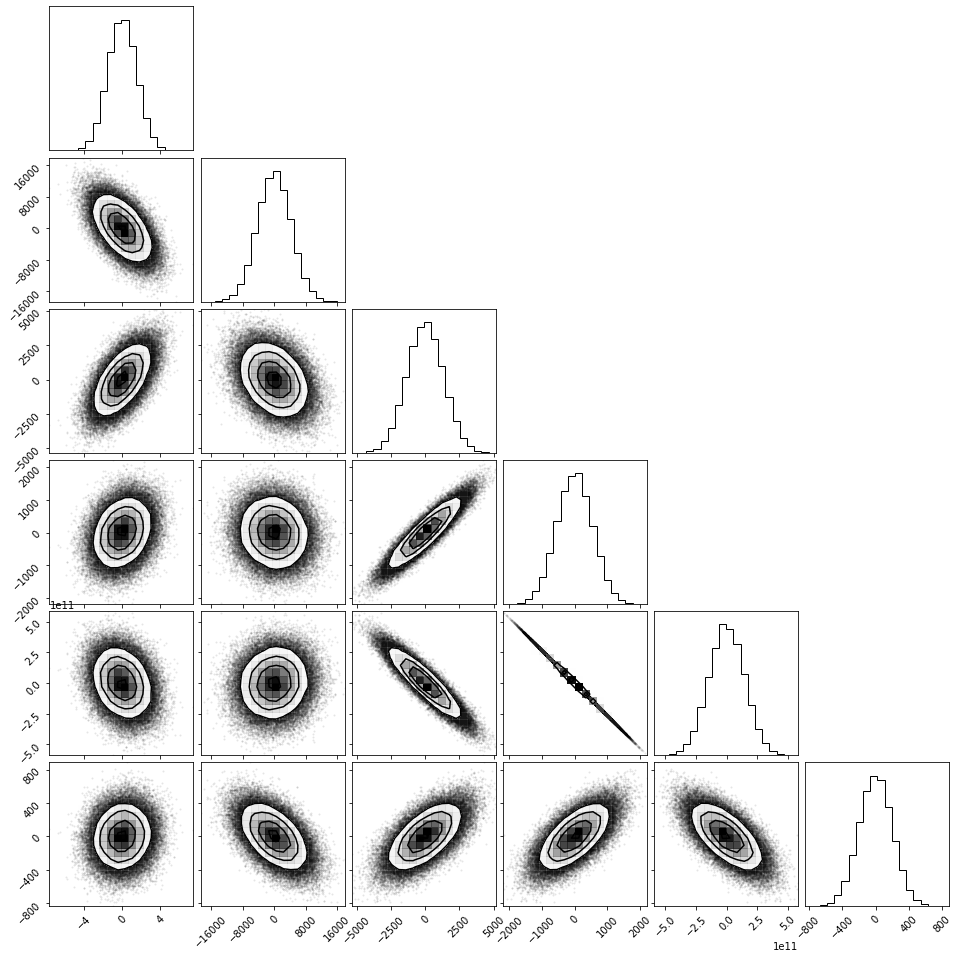

In [101]:
#[ Testing corner ]

Cholesky = np.linalg.cholesky(lhs)
testing = np.array([np.dot(Cholesky, np.random.randn(Cholesky.shape[0])) for i in range(100000)])
corner.corner(testing)
plt.show()

#personal note: if range is 100, will warn about small number of contour...

# Problem 4

A good guide for MCMC:\
https://jellis18.github.io/post/2018-01-02-mcmc-part1/ \
Unfortunately there is no part 2


In [4]:
############## for PROBLEM 4 and 5 ##############

#[ setting Data ]
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
y = wmap[:,1]
ylen = len(y)
sig = wmap[:,2]
N = np.diag(sig**2) #error from data
Ninv = np.linalg.inv(N)
#parameter  = 3 #making parameter no. constant
#chisq=np.sum((wmap[:,1]-cmb[2:wmapLen+2,])**2/N**2)

In [5]:
############## for PROBLEM 4 and 5 ##############

# running Newton's method to get initial parameter guess and step

#[ iterative Newton ]
def newtonize(y, get_spectrum, f, pars_cur, Ninv, parameter=None):
    """
    y : cmb data
    get_spectrum : camb function
    pars_cur : current parameter
    parameter : set parameter number to make it constant
                set None if to vary each one
    """
    ylen = len(y)
    for iter in range(5):
        try:
            y_raw = get_spectrum(pars_cur)
            y_pred = y_raw[2:ylen+2,]
            resid=y-y_pred #data minus current model
            #print("Finding derivatives...")
            #derivs_raw = f(y,pars_cur,parameter)
            derivs = f(y,pars_cur,parameter)

            #derivs = np.delete(derivs_raw, parameter, axis=1)
            #print("Calculating new parameters...")
            rhs=derivs.T@(Ninv@resid)
            lhs=derivs.T@Ninv@derivs
            #step_raw=np.linalg.inv(lhs)@rhs
            step = np.linalg.inv(lhs)@rhs
            #step = np.insert(step_raw, parameter, 0, axis=0)
            pars_cur=pars_cur+step
            #print('iteration ',iter,' has step ',step)
            if iter == 0:
                y_init = y_pred
                chisq=np.sum((resid)**2/sig**2)
                #print("Initial chi-square:", chisq)
            else:
                prev_chisq = chisq
                chisq = np.sum((resid)**2/sig**2)
                #print("New chi-square:", chisq)

                # if tau goes negative
                if pars_cur[3] > 0:
                    current_params = pars_cur
                    current_y = y_pred
                    lhs_check = lhs
                else:
                    #print("Tau is negative.")
                    pass

                change_chisq = np.abs(chisq - prev_chisq)/prev_chisq
                if change_chisq < 0.01:
                    break
        except:
            print('Problem with input values for get_spectrum()')
            break
    
    #send lhs_check to cholesky
    send_to_cholesky = np.linalg.inv(lhs_check)
    par_errs = np.sqrt(np.diag(send_to_cholesky))
    
    return current_y, current_params, par_errs, send_to_cholesky


In [6]:
############## for PROBLEM 4 and 5 ##############


#code from class
#pars = current_params
#data = [x,y,noise] = [residual, noise], reduce the size
#par_step = par_errs
#chifun = our_chisq

#[ calculate chi-square ]
def our_chisq(y, y_pred, noise):
    #we need a function that calculates chi^2 for us for the MCMC
    #routine to call
    chisq=np.sum( (y-y_pred)**2/noise**2)
    return chisq

#[ sample correlated data ]
def sample_cor_data(mat):
    r = np.linalg.cholesky(mat)
    return np.dot(r, np.random.randn(r.shape[0]))

In [7]:
############## for PROBLEM 4 and 5 ##############

#[ guessing initial parameters ]
parameter = None
pars_guess = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
pars_cur=pars_guess.copy()

#getting the lhs to cholesky
y_pred, current_params, par_errs, cholesky_lhs = newtonize(y, get_spectrum, f, pars_cur, Ninv)

In [56]:
#code from class

#[ start time ]
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print("Start Time:",current_time)
print("")
#[ initialize variables: variables ]
noise = sig
par_step = par_errs
chifun = our_chisq
nstep = 1000
#pars = current_params
pars = pars_cur

npar=len(pars)
chain=np.zeros([nstep,npar])
chivec=np.zeros(nstep)
ylen=len(y)
y_raw = get_spectrum(pars)
y_pred = y_raw[2:ylen+2,]
chi_cur=chifun(y, y_pred, noise)
#[ initialize variables: zero variables ]
count = 0
problematic_count = 0
problem = []
chain_mat = []
chivec_mat = []

iteration = 0
total_loop = 0

print("Initial Parameters")
print(pars)
print("")
#had to change for-loop (code from class) to a while loop
#since it saves some zero values to chain and chivec
start = time.time()
while iteration < nstep+1:
    total_loop += 1
    try:
        #print(i)
        #pars_trial=pars+np.random.randn(npar)*par_step
        pars_trial = pars + sample_cor_data(cholesky_lhs)
        #print(pars_trial)
        if pars_trial[3] < 0:
            #print(i,'REJECT!')
            pass
        else:
            #%time y_raw = get_spectrum(pars_trial)
            y_raw = get_spectrum(pars_trial)
            y_pred = y_raw[2:ylen+2,]
            #print(pars_trial)
            chi_trial=chifun(y, y_pred, noise)
            #we now have chi^2 at our current location
            #and chi^2 in our trial location. decide if we take the step
            #print(chi_cur)
            #print(chi_trial)
            #print(total_loop)
            accept_prob=np.exp(-0.5*(chi_trial-chi_cur))
            #print(accept_prob)
            if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
                count += 1
                iteration += 1
                pars=pars_trial
                chi_cur=chi_trial
                
                chain_mat.append(pars)
                chivec_mat.append(chi_cur)
                
            chain[iteration,:]=pars
            chivec[iteration]=chi_cur
        
                
    except:
        #when get_spectrum() function could not handle input parameters
        problematic_count += 1
        problem.append(total_loop)
        continue
    if (total_loop%1000 == 0):
        elapsed_time = time.time() - start
        print("total iteration so far:",total_loop,"at",round(elapsed_time, 2),"sec")
    

    #chain[i,:]=pars
    #chivec[i]=chi_cur

end = time.time() - start
accept_rate = 100 * iteration/total_loop
print("")
print("number of acceptance:" , count)
print("process time:", end)
print("total no. of iteration:", total_loop)
print("acceptance rate (%):", round(accept_rate,2))
print("")
#[ end time ]
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print("End Time:",current_time)

Start Time: 11:32:07

Initial Parameters
[6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]

total iteration so far: 1000 at 1659.64 sec
total iteration so far: 2000 at 3230.25 sec
total iteration so far: 3000 at 4613.6 sec
total iteration so far: 4000 at 5919.18 sec
total iteration so far: 5000 at 7135.81 sec
total iteration so far: 6000 at 8335.7 sec
total iteration so far: 7000 at 9569.93 sec
total iteration so far: 8000 at 10826.85 sec
total iteration so far: 9000 at 12017.72 sec
total iteration so far: 10000 at 13277.47 sec
total iteration so far: 11000 at 14525.46 sec
total iteration so far: 12000 at 15807.54 sec

number of acceptance: 1001
process time: 16540.034642457962
total no. of iteration: 12553
acceptance rate (%): 7.97

End Time: 16:07:49


In [90]:
print("got excepted:",problematic_count)
chainx = np.asarray(chain_mat)
chivecx = np.asarray(chivec_mat)

got excepted: 13


In [131]:
params_mean = np.zeros(6)
params_std = np.zeros(6)
for i in range (6):
    params_mean[i] = np.mean(chain[1:,i])
    params_std[i] = np.std(chain[1:,i])
    
print('Final parameters')
for i in range (len(params_mean)):
    if i == 4:
        print("Parameter",i+1,": %.2e" % params_mean[i],'±', "%.1e" % params_std[i])
    else: 
        print("Parameter",i+1,": %.2f" % params_mean[i],'±', "%.4f" % params_std[i])

Final parameters
Parameter 1 : 70.68 ± 2.7412
Parameter 2 : 0.02 ± 0.0006
Parameter 3 : 0.11 ± 0.0057
Parameter 4 : 0.08 ± 0.0523
Parameter 5 : 2.18e-09 ± 2.2e-10
Parameter 6 : 0.98 ± 0.0176


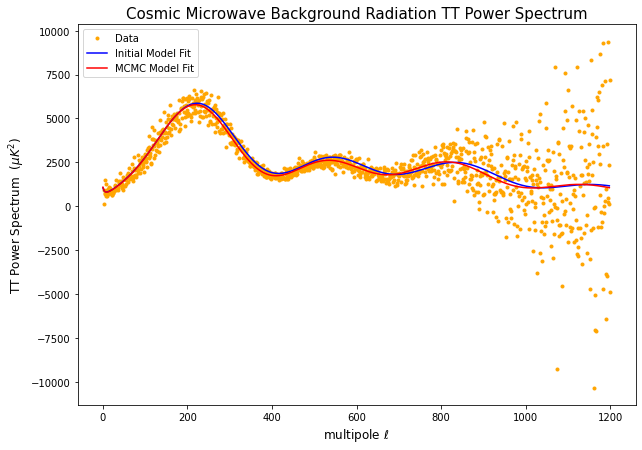

In [133]:
#plot of the model
init_pars = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
y_init_raw = get_spectrum(init_pars)
y_init = y_init_raw[2:1199+2,]

y_mcmc_raw = get_spectrum(params_mean)
y_mcmc = y_mcmc_raw[2:1199+2,]

plt.figure(figsize=(10,7))
plt.plot(wmap[:,0],wmap[:,1],'.',label = 'Data',c='orange')
plt.plot(y_init,label = 'Initial Model Fit', c='b')
plt.plot(y_mcmc, label = 'MCMC Model Fit', c='r')

plt.title("Cosmic Microwave Background Radiation TT Power Spectrum", fontsize = 15, loc='center')
plt.ylabel("TT Power Spectrum  $ (\mu K^2)$", fontsize = 12)
plt.xlabel("multipole $\ell$", fontsize = 12)
plt.legend()
plt.show()

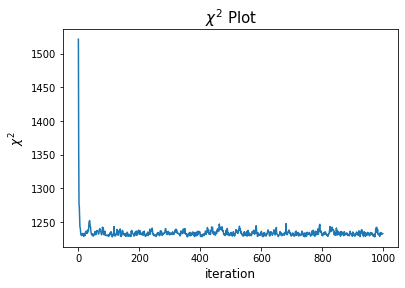

In [107]:
#chi-squared plot
plt.plot(chivec[1:])
plt.title('$\chi^2$ Plot', fontsize = 15, loc='center')
plt.ylabel('$\chi^2$', fontsize = 12)
plt.xlabel('iteration', fontsize = 12)
plt.show()

Markov Chains of the Parameters


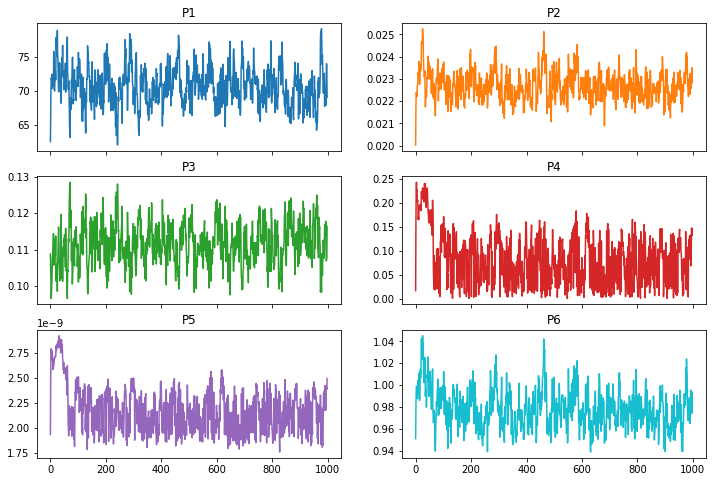

In [102]:
#Plot of Markov Chains
print("Markov Chains of the Parameters")
fig, axs = plt.subplots(3, 2, figsize=(12,8),sharex=True)
axs[0, 0].plot(chain[1:,0])
axs[0, 0].set_title('P1')
axs[0, 1].plot(chain[1:,1], 'tab:orange')
axs[0, 1].set_title('P2')
axs[1, 0].plot(chain[1:,2], 'tab:green')
axs[1, 0].set_title('P3')
axs[1, 1].plot(chain[1:,3], 'tab:red')
axs[1, 1].set_title('P4')
axs[2, 0].plot(chain[1:,4], 'tab:purple')
axs[2, 0].set_title('P5')
axs[2, 1].plot(chain[1:,5], 'tab:cyan')
axs[2, 1].set_title('P6')

#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
plt.show()

From the figures, the chains are converged since the play around certain values if you draw horizontal line on them.

Corner Plot of the Parameters


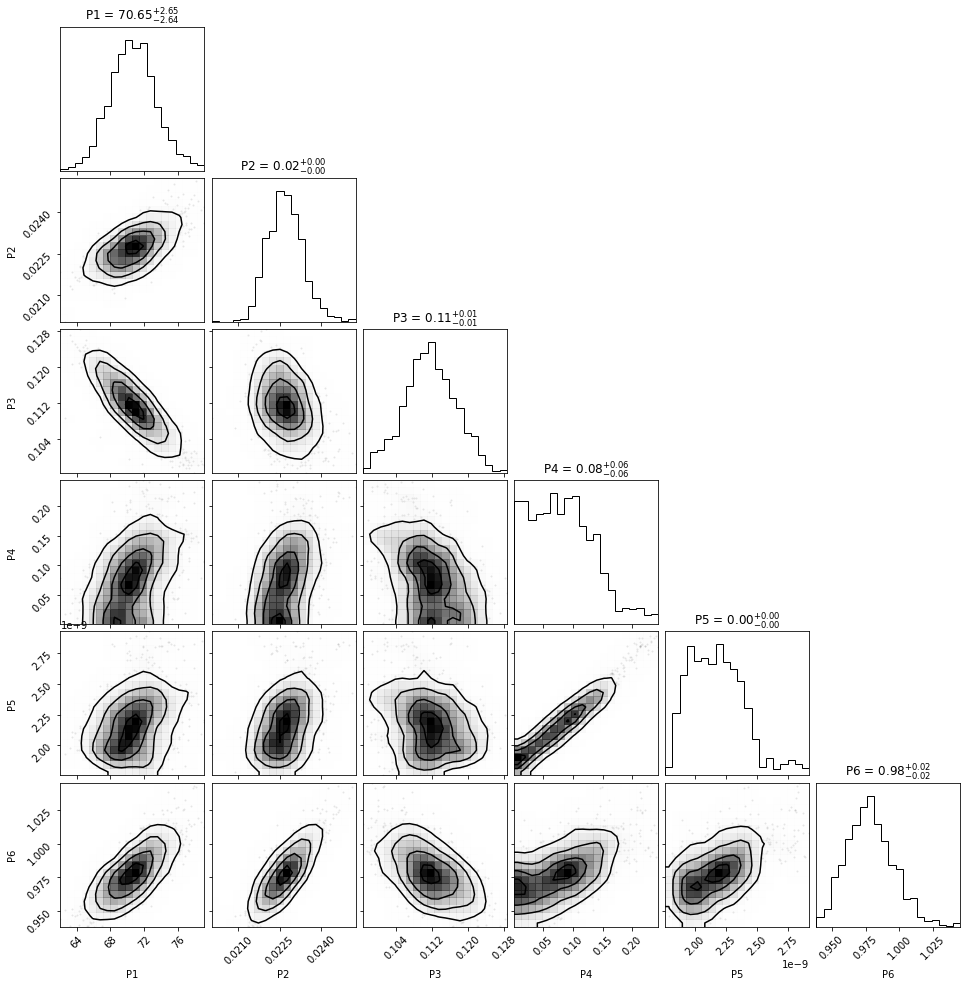

In [105]:
#corner plot
print('Corner Plot of the Parameters')
check_the_label = ["P1","P2","P3","P4","P5","P6"]
corner.corner(chainx,labels=check_the_label, smooth = True, show_titles=True,title_fmt='.2f')
plt.show()

In [258]:
len(chains)

100

# Problem 5

In [9]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [8]:
#adding weighting factor to our_chisq

def weighted_chisq(y, y_pred, noise, tau_param):
    #adding the tau param chi-square to over-all chi-square
    chisq=np.sum( (y-y_pred)**2/noise**2 ) + ((tau_param - 0.0544)/0.0073)**2
    return chisq

In [11]:
# test for samples of  N(mean, sigma squared)

tau_mean = 0.0544
tau_sig = 0.0073
tau_sig * np.random.randn(1) + tau_mean

array([0.03887786])

In [9]:
#code from class

#[ start time ]
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print("Start Time:",current_time)
print("")
#[ initialize variables: variables ]
tau_mean = 0.0544
tau_sig = 0.0073
noise = sig
par_step = par_errs
chifun = weighted_chisq
nstep = 1000
#pars = current_params
pars = pars_cur
pars[3] = tau_mean
npar=len(pars)
wchain=np.zeros([nstep,npar])
wchivec=np.zeros(nstep)
ylen=len(y)
y_raw = get_spectrum(pars)
y_pred = y_raw[2:ylen+2,]
chi_cur=chifun(y, y_pred, noise, pars[3])
#[ initialize variables: zero variables ]
count = 0
problematic_count = 0
problem = []
wchain_mat = []
wchivec_mat = []

iteration = 0
total_loop = 0

print("Initial Parameters")
print(pars)
print("")
#had to change for-loop (code from class) to a while loop
#since it saves some zero values to chain and chivec
start = time.time()
while iteration < nstep+1:
    total_loop += 1
    if total_loop == 20000:
        break
    try:
        #print(i)
        #pars_trial=pars+np.random.randn(npar)*par_step
        # Scaling of 0.7 as suggested by Marcus
        pars_trial = pars + sample_cor_data(cholesky_lhs)
        #prior
        pars_trial[3] = tau_sig * np.random.randn(1) + tau_mean
        #print(pars_trial)
        if pars_trial[3] < 0:
            #print(i,'REJECT!')
            pass
        else:
            #%time y_raw = get_spectrum(pars_trial)
            y_raw = get_spectrum(pars_trial)
            y_pred = y_raw[2:ylen+2,]
            #print(pars_trial)
            chi_trial=chifun(y, y_pred, noise, pars_trial[3])
            #we now have chi^2 at our current location
            #and chi^2 in our trial location. decide if we take the step
            #print(chi_cur)
            #print(chi_trial)
            #print(total_loop)
            accept_prob=np.exp(-0.5*(chi_trial-chi_cur))
            #print(accept_prob)
            if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
                count += 1
                iteration += 1
                pars=pars_trial
                chi_cur=chi_trial
                
                wchain_mat.append(pars)
                wchivec_mat.append(chi_cur)
                
            wchain[iteration,:]=pars
            wchivec[iteration]=chi_cur
        
                
    except:
        #when get_spectrum() function could not handle input parameters
        problematic_count += 1
        problem.append(total_loop)
        continue
    if (total_loop%1000 == 0):
        elapsed_time = time.time() - start
        print("total iteration so far:",total_loop,"at",round(elapsed_time, 2),"sec")
        print("and accepted iteration:", iteration)
        print("number of get_spectrum() problem:",problematic_count)
    
df_wchain_mat = pd.DataFrame(wchain_mat)
df_wchivec_mat = pd.DataFrame(wchivec_mat)
df_wchain = pd.DataFrame(wchain) 
df_wchivec = pd.DataFrame(wchivec)

df_wchain_mat.to_csv('weighted_chain_mat.csv')
df_wchivec_mat.to_csv('weighted_chivec_mat.csv')
df_wchain.to_csv('weighted_chain.csv')
df_wchivec.to_csv('weighted_chivec.csv')
    #chain[i,:]=pars
    #chivec[i]=chi_cur

end = time.time() - start
accept_rate = 100 * iteration/total_loop
print("")
print("number of acceptance:" , count)
print("process time:", end)
print("total no. of iteration:", total_loop)
print("acceptance rate (%):", round(accept_rate,2))
print("")
#[ end time ]
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print("End Time:",current_time)

Start Time: 07:35:45

Initial Parameters
[6.50e+01 2.00e-02 1.00e-01 5.44e-02 2.00e-09 9.60e-01]

total iteration so far: 1000 at 2024.15 sec
and accepted iteration: 18
number of get_spectrum() problem: 0
total iteration so far: 2000 at 4024.96 sec
and accepted iteration: 28
number of get_spectrum() problem: 0
total iteration so far: 3000 at 5976.26 sec
and accepted iteration: 32
number of get_spectrum() problem: 0
total iteration so far: 4000 at 7937.42 sec
and accepted iteration: 45
number of get_spectrum() problem: 0
total iteration so far: 5000 at 9912.87 sec
and accepted iteration: 55
number of get_spectrum() problem: 0
total iteration so far: 6000 at 11906.63 sec
and accepted iteration: 63
number of get_spectrum() problem: 0
total iteration so far: 7000 at 13890.57 sec
and accepted iteration: 74
number of get_spectrum() problem: 0
total iteration so far: 8000 at 15881.86 sec
and accepted iteration: 79
number of get_spectrum() problem: 0
total iteration so far: 9000 at 17872.43 se

The acceptance rate is less than 1%. This means that to be able to get about 1000 sets (having the same number points as the previous problem would allow us to make a better comparison), we need to run at least 110,000 loops. Assuming that the acceptance rate is the same on the average and the processing time behaves linearly, then we will need at least 60 hours of run time -- which is relatively infeasible. As you will see in the chi-square plot later, it is somewhat similar to the chi-square plot of the previous problem.

In [25]:
df_wchain_mat = pd.DataFrame(wchain_mat)
df_wchivec_mat = pd.DataFrame(wchivec_mat)
df_wchain = pd.DataFrame(wchain) 
df_wchivec = pd.DataFrame(wchivec)

df_wchain_mat.to_csv('weighted_chain_mat.csv')
df_wchivec_mat.to_csv('weighted_chivec_mat.csv')
df_wchain.to_csv('weighted_chain.csv')
df_wchivec.to_csv('weighted_chivec.csv')

In [11]:
#Cosmic Microwave Background Radiation Parameters using Markov Chain Monte Carlo
#[ this prints parameter values ]
wparams_mean = np.zeros(6)
wparams_std = np.zeros(6)
for i in range (6):
    wparams_mean[i] = np.mean(wchain[1:iteration+1:,i])
    wparams_std[i] = np.std(wchain[1:iteration+1:,i])
    
print('Final parameters')
for i in range (len(wparams_mean)):
    if i == 4:
        print("Parameter",i+1,": %.2e" % wparams_mean[i],'±', "%.1e" % wparams_std[i])
    else: 
        print("Parameter",i+1,": %.2f" % wparams_mean[i],'±', "%.4f" % wparams_std[i])

Final parameters
Parameter 1 : 68.68 ± 2.8715
Parameter 2 : 0.02 ± 0.0010
Parameter 3 : 0.11 ± 0.0048
Parameter 4 : 0.05 ± 0.0059
Parameter 5 : 2.07e-09 ± 5.0e-11
Parameter 6 : 0.97 ± 0.0148


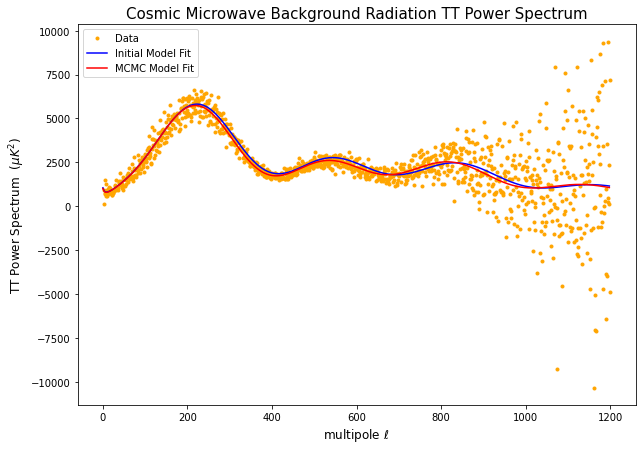

In [16]:
#plot of the model
init_pars = np.asarray([65,0.02,0.1,0.0544,2e-9,0.96])
y_init_raw = get_spectrum(init_pars)
y_init = y_init_raw[2:1199+2,]

wy_mcmc_raw = get_spectrum(wparams_mean)
wy_mcmc = wy_mcmc_raw[2:1199+2,]

plt.figure(figsize=(10,7))
plt.plot(wmap[:,0],wmap[:,1],'.',label = 'Data',c='orange')
plt.plot(y_init,label = 'Initial Model Fit', c='b')
plt.plot(wy_mcmc, label = 'MCMC Model Fit', c='r')

plt.title("Cosmic Microwave Background Radiation TT Power Spectrum", fontsize = 15, loc='center')
plt.ylabel("TT Power Spectrum  $ (\mu K^2)$", fontsize = 12)
plt.xlabel("multipole $\ell$", fontsize = 12)
plt.legend()
plt.show()

Markov Chains of the Parameters


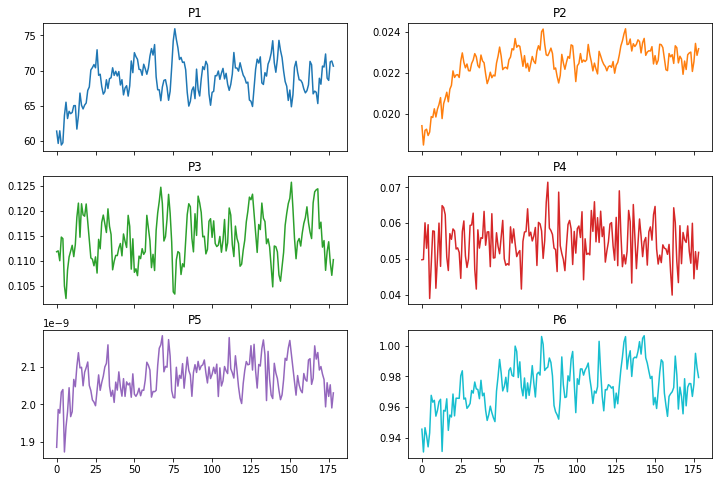

In [17]:
#Plot of Markov Chains
print("Markov Chains of the Parameters")
fig, axs = plt.subplots(3, 2, figsize=(12,8),sharex=True)
axs[0, 0].plot(wchain[1:iteration+1:,0])
axs[0, 0].set_title('P1')
axs[0, 1].plot(wchain[1:iteration+1:,1], 'tab:orange')
axs[0, 1].set_title('P2')
axs[1, 0].plot(wchain[1:iteration+1:,2], 'tab:green')
axs[1, 0].set_title('P3')
axs[1, 1].plot(wchain[1:iteration+1:,3], 'tab:red')
axs[1, 1].set_title('P4')
axs[2, 0].plot(wchain[1:iteration+1:,4], 'tab:purple')
axs[2, 0].set_title('P5')
axs[2, 1].plot(wchain[1:iteration+1:,5], 'tab:cyan')
axs[2, 1].set_title('P6')

#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
plt.show()

This has not converged.

In [27]:
chi_mean = np.mean(wchivec[25:iteration+1])
chi_std = np.std(wchivec[25:iteration+1])

print("Chi-square mean for MCMC (#5):", ": %.f" % chi_mean)
print("Chi-square std for MCMC (#5):", ": %.f" % chi_std)

Chi-square mean for MCMC (#5): : 1234
Chi-square std for MCMC (#5): : 3


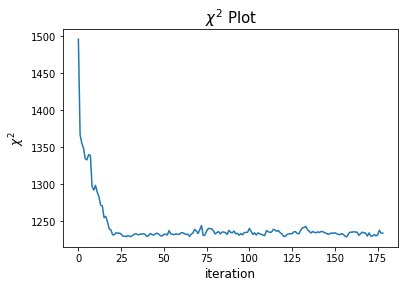

In [18]:
#chi-squared plot
plt.plot(wchivec[1:iteration+1:])
plt.title('$\chi^2$ Plot', fontsize = 15, loc='center')
plt.ylabel('$\chi^2$', fontsize = 12)
plt.xlabel('iteration', fontsize = 12)
plt.show()

Corner Plot of the Parameters


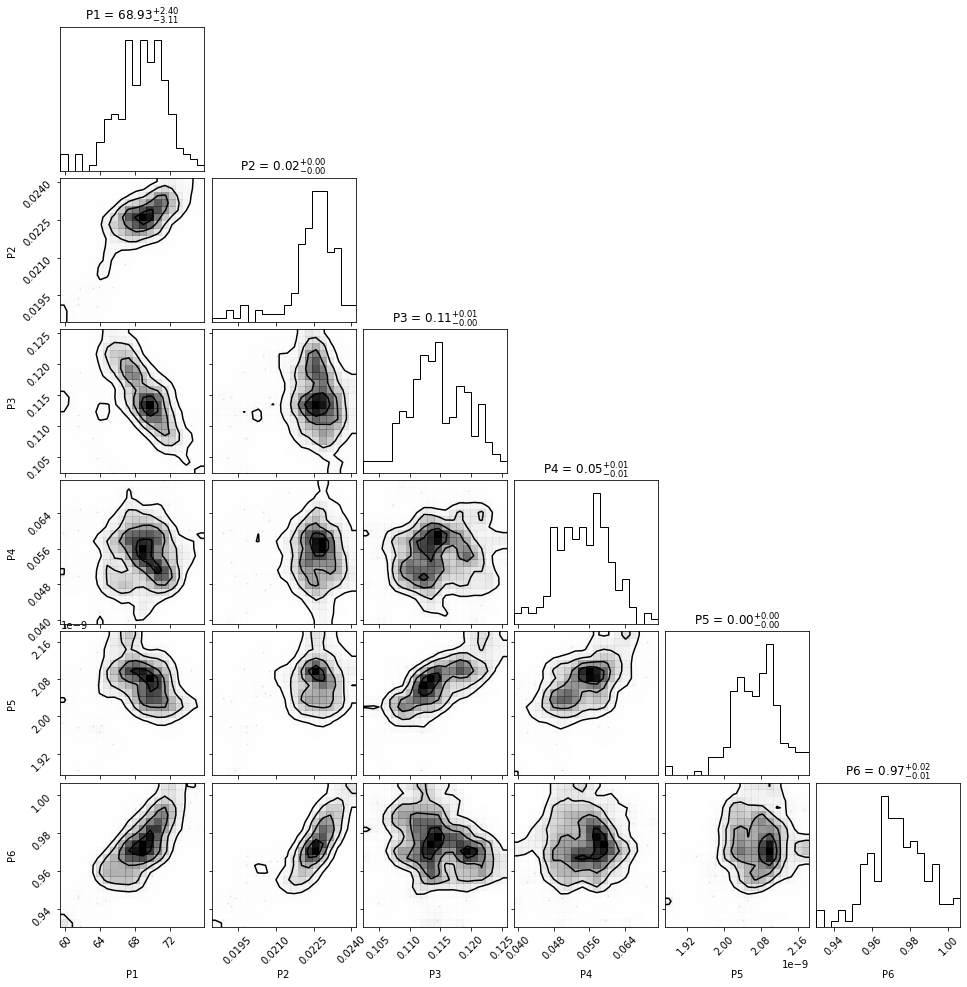

In [23]:
#corner plot
print('Corner Plot of the Parameters')
check_the_label = ["P1","P2","P3","P4","P5","P6"]
corner.corner(wchain[1:iteration+1],labels=check_the_label, smooth = True, show_titles=True,title_fmt='.2f')
plt.show()

In [146]:
############ DO NOT RE-RUN ###############


#weighting of chain from problem 4
#using DescrStatsW from statsmodels.stats.weightstats to for weighted factor
# Planck tau = 0.0544 ± 0.0073

tau_mean = 0.0544
tau_sig = 0.0073
wFactor = np.exp(-0.5*((chain[1:,4] - tau_mean)/tau_sig)**2)

weighted_params = np.zeros(6)
weighted_std = np.zeros(6)

for i in range (6):
    weighted_stats = DescrStatsW(chain[1:,i], weights=wFactor, ddof=0)
    weighted_params[i] = weighted_stats.mean
    weighted_std[i] = weighted_stats.std
    
print('Final weighted parameters')
for i in range (len(weighted_params)):
    if i == 4:
        print("Parameter",i+1,": %.2e" % weighted_params[i],'±', "%.1e" % weighted_std[i])
    else: 
        print("Parameter",i+1,": %.2f" % weighted_params[i],'±', "%.4f" % weighted_std[i])

Final weighted parameters
Parameter 1 : 70.68 ± 2.7412
Parameter 2 : 0.02 ± 0.0006
Parameter 3 : 0.11 ± 0.0057
Parameter 4 : 0.08 ± 0.0523
Parameter 5 : 2.18e-09 ± 2.2e-10
Parameter 6 : 0.98 ± 0.0176


Compared to item #4, these values are remarkably similar or the same. For the MCMC here, all parameters have values within their errors except for parameter 4 (since this is a prior) and parameter 5 (this made the acceptance rate small compared to previous problem).

# CAUTION: YOU MAY NOT PROCEED

The following lines are remnants of the struggle in making problem 4 and 5 work! I would like to keep it as souvenir.

In [148]:
#weighting of chain from problem 4
#using DescrStatsW from statsmodels.stats.weightstats to for weighted factor
# Planck tau = 0.0544 ± 0.0073

tau_mean = 0.0544
tau_sig = 0.0073
wFactor = np.exp(-0.5*((chain[1:,4] - tau_mean)/tau_sig)**2)

weighted_params = np.zeros(6)
weighted_std = np.zeros(6)

for i in range (6):
    weighted_stats = DescrStatsW(chain[1:,i], weights=wFactor, ddof=0)
    weighted_params[i] = weighted_stats.mean
    weighted_std[i] = weighted_stats.std
    
print('Final weighted parameters')
for i in range (len(weighted_params)):
    if i == 4:
        print("Parameter",i+1,": %.2e" % weighted_params[i],'±', "%.1e" % weighted_std[i])
    else: 
        print("Parameter",i+1,": %.2f" % weighted_params[i],'±', "%.4f" % weighted_std[i])

Final weighted parameters
Parameter 1 : 70.68 ± 2.7412
Parameter 2 : 0.02 ± 0.0006
Parameter 3 : 0.11 ± 0.0057
Parameter 4 : 0.08 ± 0.0523
Parameter 5 : 2.18e-09 ± 2.2e-10
Parameter 6 : 0.98 ± 0.0176


In [6]:
#code from class
#pars = current_params
#data = [x,y,noise] = [residual, noise], reduce the size
#par_step = par_errs
#chifun = our_chisq

def our_chisq(y, y_pred, noise):
    #we need a function that calculates chi^2 for us for the MCMC
    #routine to call
    chisq=np.sum( (y-y_pred)**2/noise**2)
    return chisq

def run_mcmc(y, y_pred, noise, pars, par_step, chifun, nstep=5000):
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    ylen=len(y)
    print(pars)
    chi_cur=chifun(y, y_pred, noise)
    for i in range(nstep):
        #print(i)
        pars_trial=pars+np.random.randn(npar)*par_step
        #print(pars_trial)
        if pars_trial[3] < 0:
            #print(i,'REJECT!')
            pass
        else:
            %time y_raw = get_spectrum(pars_trial)
            y_pred = y_raw[2:ylen+2,]
            print(y_pred)
            chi_trial=chifun(y, y_pred, noise)
            #we now have chi^2 at our current location
            #and chi^2 in our trial location. decide if we take the step
            print(chi_cur)
            print(chi_trial)
            
            accept_prob=np.exp(-0.5*(chi_trial-chi_cur))
            #print(accept_prob)
            if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
                print(i)
                pars=pars_trial
                chi_cur=chi_trial
        chain[i,:]=pars
        chivec[i]=chi_cur
    return chain,chivec

def sample_cor_data(mat):
    r = np.linalg.cholesky(mat)
    return np.dot(r, np.random.randn(r.shape[0]))

In [224]:
#pars_guess = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
#pars_cur=pars_guess.copy()
#y_raw = get_spectrum(pars_cur)
#y_pred = y_raw[2:ylen+2,]
par_kour = np.asarray([1e1,1e-3,1e-2,1e-3,1e-10,1e-2])
chain,chivec=run_mcmc(y, y_pred, sig, current_params, par_errs,our_chisq,nstep=20)
par_sigs=np.std(chain,axis=0)
par_means=np.mean(chain,axis=0)

[6.85259005e+01 2.23300515e-02 1.15339049e-01 1.04669740e-02
 1.88815034e-09 9.64121662e-01]
Wall time: 1.75 s
[1047.11471908  981.82978005  922.7341584  ... 1168.24734652 1165.06298721
 1161.81386789]
1235.398870041362
1588.2376532931526
Wall time: 1.78 s
[1047.11471908  981.82978005  922.7341584  ... 1168.24734652 1165.06298721
 1161.81386789]
1235.398870041362
1588.2376532931526
Wall time: 1.93 s
[1047.11471908  981.82978005  922.7341584  ... 1168.24734652 1165.06298721
 1161.81386789]
1235.398870041362
1588.2376532931526
Wall time: 1.65 s
[1047.11471908  981.82978005  922.7341584  ... 1168.24734652 1165.06298721
 1161.81386789]
1235.398870041362
1588.2376532931526
Wall time: 2.1 s
[1047.11471908  981.82978005  922.7341584  ... 1168.24734652 1165.06298721
 1161.81386789]
1235.398870041362
1588.2376532931526
Wall time: 1.64 s
[1047.11471908  981.82978005  922.7341584  ... 1168.24734652 1165.06298721
 1161.81386789]
1235.398870041362
1588.2376532931526
Wall time: 2.14 s
[1047.11471908

In [220]:
par_errs

array([3.19142592e+00, 7.94608850e-04, 6.36145958e-03, 1.50810165e-01,
       5.99207914e-10, 2.27937318e-02])

In [217]:
parkss_guess = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
parkss_cur=parkss_guess.copy()
yks_raw = get_spectrum(parkss_cur)
yks_pred = yks_raw[2:ylen+2,]
yks_pred

array([1047.11471908,  981.82978005,  922.7341584 , ..., 1168.24734652,
       1165.06298721, 1161.81386789])

In [8]:
noise = sig
par_step = par_errs
chifun = our_chisq
nstep = 10000
pars = current_params

npar=len(pars)
chain=np.zeros([nstep,npar])
chivec=np.zeros(nstep)
ylen=len(y)
print(pars)
chi_cur=chifun(y, y_pred, noise)
count = 0
problematic_count = 0
problem = []
start = time.time()
for i in range(nstep):
    try:
        #print(i)
        pars_trial=pars+np.random.randn(npar)*par_step
        #print(pars_trial)
        if pars_trial[3] < 0:
            #print(i,'REJECT!')
            pass
        else:
            #%time y_raw = get_spectrum(pars_trial)
            y_raw = get_spectrum(pars_trial)
            y_pred = y_raw[2:ylen+2,]
            #print(pars_trial)
            chi_trial=chifun(y, y_pred, noise)
            #we now have chi^2 at our current location
            #and chi^2 in our trial location. decide if we take the step
            #print(chi_cur)
            #print(chi_trial)

            accept_prob=np.exp(-0.5*(chi_trial-chi_cur))
            #print(accept_prob)
            if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
                count += 1
                pars=pars_trial
                chi_cur=chi_trial

    except:
        #when get_spectrum() function could not handle input parameters
        problematic_count += 1
        problem.append(i)
        continue
    if (i%1000 == 0):
        elapsed_time = time.time() - start
        print("iteration no.",i,":",round(elapsed_time, 2),"sec")
        
    chain[i,:]=pars
    chivec[i]=chi_cur
end = time.time() - start
print("number of acceptance:" , count)
print("process time:", end)

[6.85259005e+01 2.23300515e-02 1.15339049e-01 1.04669740e-02
 1.88815034e-09 9.64121662e-01]
iteration no. 0 : 0.0 sec
iteration no. 1000 : 1260.54 sec
iteration no. 2000 : 2471.32 sec
iteration no. 3000 : 3499.13 sec
iteration no. 4000 : 5021.54 sec
iteration no. 5000 : 6961.47 sec
iteration no. 6000 : 8710.48 sec
iteration no. 7000 : 10447.08 sec
iteration no. 8000 : 12256.28 sec
iteration no. 9000 : 14015.18 sec
number of acceptance: 7
process time: 16329.49661564827


In [13]:
problem

[4655, 7147, 8749, 8778]

In [9]:
df = pd.DataFrame(chivec)
len(pd.unique(df[0])) 


9

In [14]:
pd.unique(df[0])

array([1235.39887004, 1233.51650275, 1233.95786045, 1233.47698731,
          0.        , 1230.93091134, 1239.93456288, 1239.65831591,
       1231.27665768])

In [ ]:
#code from class

#[ start time ]
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print("Start Time:",current_time)
print("")
#[ initialize variables: variables ]
noise = sig
par_step = par_errs
chifun = weighted_chisq
nstep = 1000
#pars = current_params
pars = pars_cur

npar=len(pars)
wchain=np.zeros([nstep,npar])
wchivec=np.zeros(nstep)
ylen=len(y)
y_raw = get_spectrum(pars)
y_pred = y_raw[2:ylen+2,]
chi_cur=chifun(y, y_pred, noise, pars[3])
#[ initialize variables: zero variables ]
count = 0
problematic_count = 0
problem = []
wchain_mat = []
wchivec_mat = []

iteration = 0
total_loop = 0

print("Initial Parameters")
print(pars)
print("")
#had to change for-loop (code from class) to a while loop
#since it saves some zero values to chain and chivec
start = time.time()
while iteration < nstep+1:
    total_loop += 1
    try:
        #print(i)
        #pars_trial=pars+np.random.randn(npar)*par_step
        # Scaling of 0.7 as suggested by Marcus
        pars_trial = pars + sample_cor_data(cholesky_lhs)*0.7
        #print(pars_trial)
        if pars_trial[3] < 0:
            #print(i,'REJECT!')
            pass
        else:
            #%time y_raw = get_spectrum(pars_trial)
            y_raw = get_spectrum(pars_trial)
            y_pred = y_raw[2:ylen+2,]
            #print(pars_trial)
            chi_trial=chifun(y, y_pred, noise, pars_trial[3])
            #we now have chi^2 at our current location
            #and chi^2 in our trial location. decide if we take the step
            #print(chi_cur)
            #print(chi_trial)
            #print(total_loop)
            accept_prob=np.exp(-0.5*(chi_trial-chi_cur))
            #print(accept_prob)
            if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
                count += 1
                iteration += 1
                pars=pars_trial
                chi_cur=chi_trial
                
                wchain_mat.append(pars)
                wchivec_mat.append(chi_cur)
                
            wchain[iteration,:]=pars
            wchivec[iteration]=chi_cur
        
                
    except:
        #when get_spectrum() function could not handle input parameters
        problematic_count += 1
        problem.append(total_loop)
        continue
    if (total_loop%1000 == 0):
        elapsed_time = time.time() - start
        print("total iteration so far:",total_loop,"at",round(elapsed_time, 2),"sec")
        print("and accepted iteration:", iteration)
    

    #chain[i,:]=pars
    #chivec[i]=chi_cur

end = time.time() - start
accept_rate = 100 * iteration/total_loop
print("")
print("number of acceptance:" , count)
print("process time:", end)
print("total no. of iteration:", total_loop)
print("acceptance rate (%):", round(accept_rate,2))
print("")
#[ end time ]
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print("End Time:",current_time)

Start Time: 23:12:23

Initial Parameters
[6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]

total iteration so far: 1000 at 1014.96 sec
total iteration so far: 2000 at 2079.86 sec
total iteration so far: 3000 at 3069.07 sec
total iteration so far: 4000 at 4103.91 sec
total iteration so far: 5000 at 5062.48 sec
total iteration so far: 6000 at 6034.8 sec
total iteration so far: 7000 at 6985.21 sec
total iteration so far: 8000 at 7974.66 sec
total iteration so far: 9000 at 8960.3 sec
total iteration so far: 10000 at 10028.39 sec
total iteration so far: 11000 at 11025.07 sec
total iteration so far: 12000 at 12132.37 sec
total iteration so far: 13000 at 13218.3 sec
total iteration so far: 14000 at 14268.04 sec
total iteration so far: 15000 at 15406.9 sec
total iteration so far: 16000 at 16545.45 sec
total iteration so far: 17000 at 17651.34 sec
total iteration so far: 18000 at 18882.04 sec
total iteration so far: 19000 at 19999.45 sec
total iteration so far: 20000 at 21188.74 sec
total iter

Start Time: 06:08:06

Initial Parameters
[6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]

total iteration so far: 1000 at 1147.61 sec
and accepted iteration: 16
total iteration so far: 2000 at 2288.16 sec
and accepted iteration: 18
total iteration so far: 3000 at 3356.9 sec
and accepted iteration: 19
total iteration so far: 4000 at 4388.16 sec
and accepted iteration: 20
total iteration so far: 5000 at 5445.96 sec
and accepted iteration: 21
total iteration so far: 6000 at 6519.11 sec
and accepted iteration: 21
total iteration so far: 7000 at 7559.84 sec
and accepted iteration: 24
total iteration so far: 8000 at 8631.06 sec
and accepted iteration: 25